In [2]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import lina



Succesfully initialized testbed interface.


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


In [20]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 500
scoobi.set_zwo_roi(xc, yc, npsf)

Succesfully initialized testbed interface.


ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...

In [56]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='nsvcam', dm_channel='dm00disp05')
# tbi.zero_dm()

Succesfully initialized testbed interface.


In [57]:
scoobi.move_psf(60, 0)

In [13]:
tbi.bias = 63

In [58]:
tbi.exp_time = 0.1*u.millisecond
tbi.Nframes = 100

In [59]:
tbi.attenuation = 26

In [60]:
tbi.normalize = True
tbi.att_ref = 26
# tbi.normalize = False

INFO:utils:Got semaphore index 1.


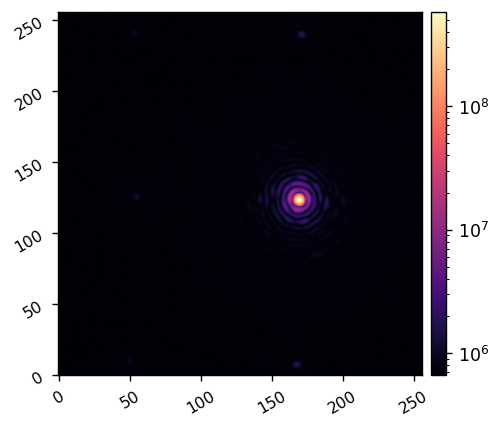

In [61]:
raw_im = tbi.snap()
imshow1(raw_im, lognorm=True,)

In [62]:
tbi.Imax_ref = xp.max(raw_im)

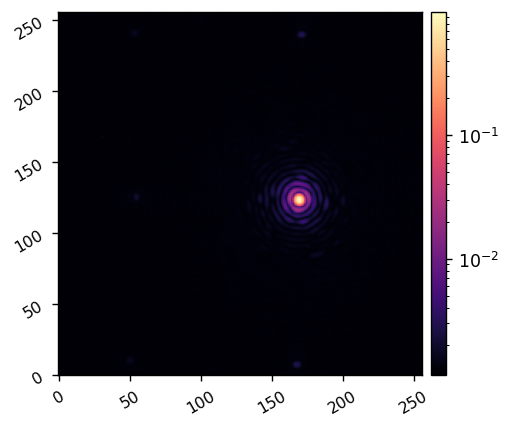

In [63]:
ref_psf = tbi.snap()
imshow1(ref_psf, lognorm=True)

In [64]:
scoobi.move_psf(-60,0)

In [65]:
tbi.exp_time = 2.5*u.millisecond

In [66]:
tbi.attenuation = 11

In [31]:
scoobi.move_psf(-1,0)

In [27]:
scoobi.move_psf(0,-1)

In [67]:
tbi.Nframes = 10

In [68]:
tbi.npsf = 128
tbi.x_shift = 3
tbi.y_shift = 5

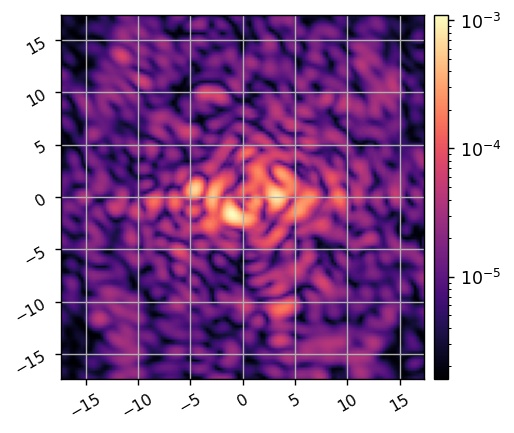

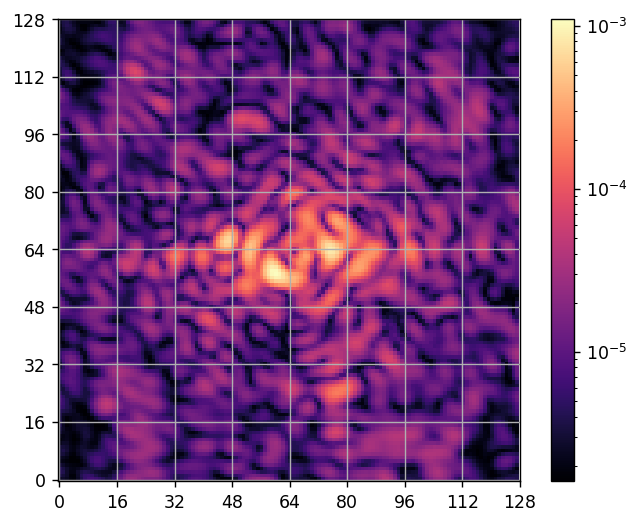

In [69]:
ref_im = tbi.snap(plot=True)

nticks = 8
ticks = np.arange(0, tbi.npsf+1, tbi.npsf//nticks)
plt.figure(dpi=125)
plt.imshow(ensure_np_array(ref_im), norm=LogNorm(), cmap='magma')
plt.colorbar()
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()



In [25]:
pixelscale_lamD = 32/(128-10)
print(pixelscale_lamD)

0.2711864406779661


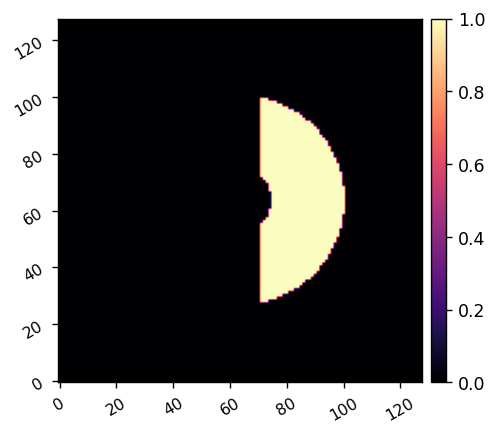

In [70]:
control_mask = lina.utils.create_annular_focal_plane_mask(tbi, 3, 10, 2, plot=True)

In [149]:
xp.mean(ref_im[control_mask])

array(5.26236394e-05)

In [71]:
probe_amp = 15e-9
probe_modes = lina.utils.create_fourier_probes(tbi, control_mask, fourier_sampling=0.25, nprobes=2)
probes = probe_amp*probe_modes

calib_amp = 5e-9
calib_modes = lina.utils.create_hadamard_modes(xp.array(tbi.dm_mask))


In [74]:
tbi.reset_dm()

In [76]:
tbi.attenuation =14

In [77]:
reload(lina.iefc)

response_matrix = lina.iefc.calibrate(tbi, 
                                      control_mask, 
                                      probe_amplitude=probe_amp, 
                                      probe_modes=probe_modes,
                                      calibration_amplitude=calib_amp,
                                      calibration_modes=calib_modes,
                                      )

Calibrating iEFC...
	Calibrated mode 1024 / 1024 in 1680.95s
Calibration complete.


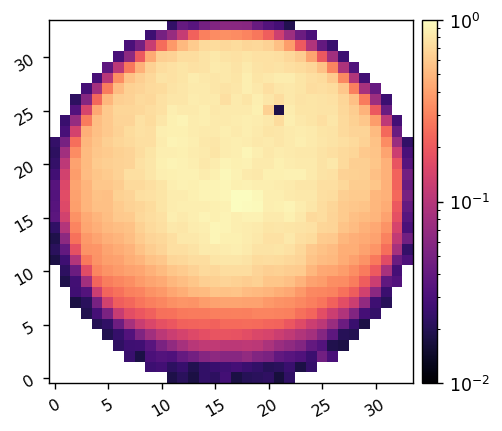

In [78]:
dm_response = xp.sqrt(xp.mean(xp.abs(response_matrix.dot(xp.array(calib_modes)))**2, axis=0))
dm_response = dm_response.reshape(tbi.Nact, tbi.Nact)/xp.max(dm_response)

imshow1(dm_response, lognorm=True, vmin=1e-2)

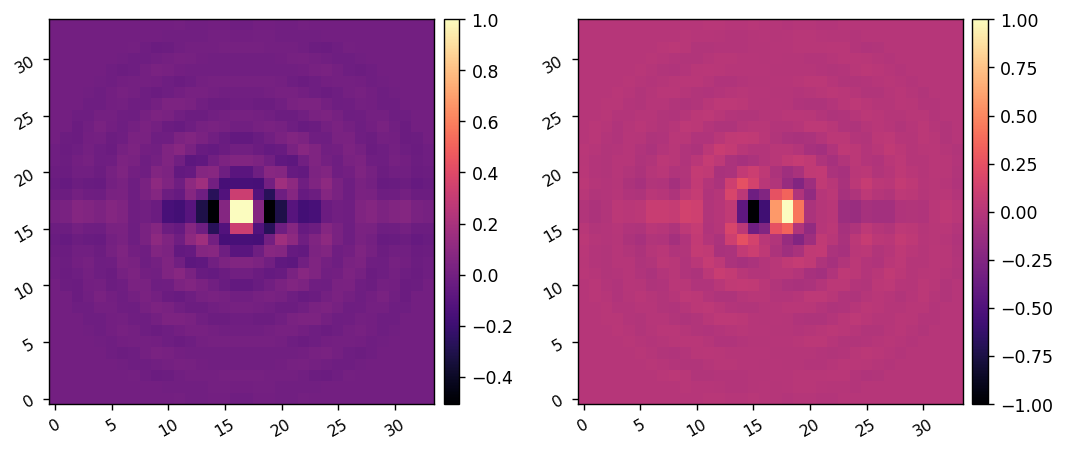

In [153]:
imshow2(probe_modes[0], probe_modes[1])

In [80]:
from astropy.io import fits
utils.save_fits(f'jacobian_iefc_{20240226}.fits', response_matrix)

Saved data to:  jacobian_iefc_20240226.fits


# Run iEFC

In [106]:
tbi.reset_dm()

images = xp.array([ref_im])
dm_commands = xp.array([tbi.get_dm()])

Running iEFC ...
	Closed-loop iteration 1 / 3
	Mean NI of this iteration: 1.677e-05


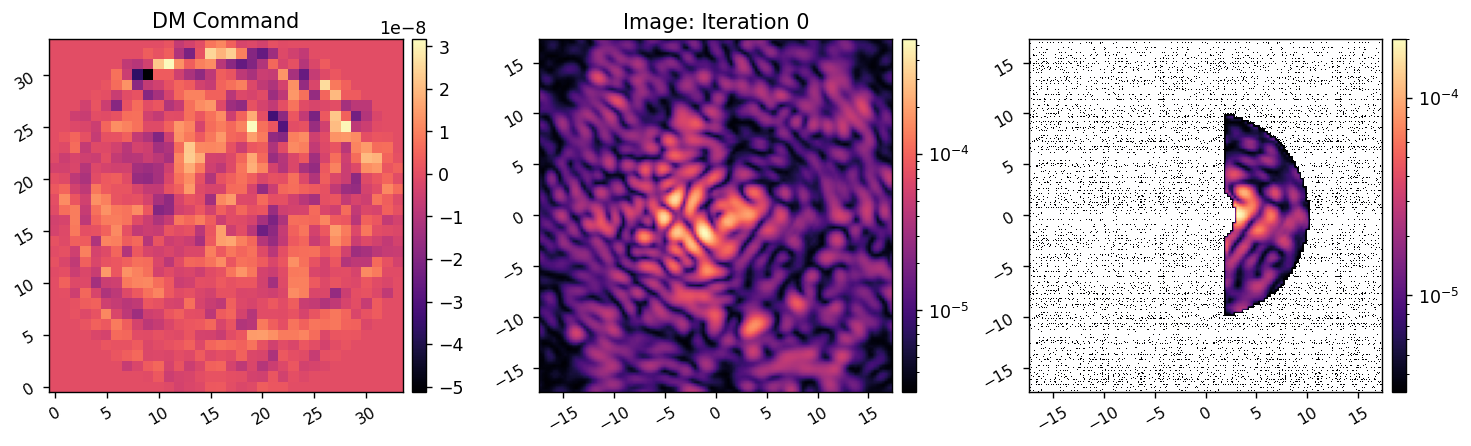

	Closed-loop iteration 2 / 3
	Mean NI of this iteration: 6.866e-06


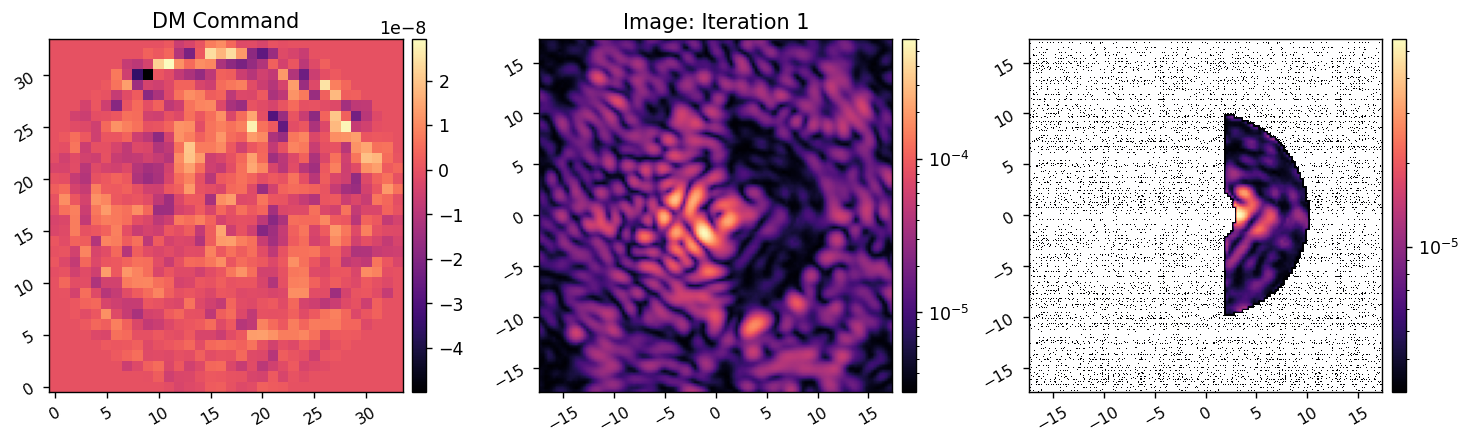

	Closed-loop iteration 3 / 3
	Mean NI of this iteration: 4.791e-06


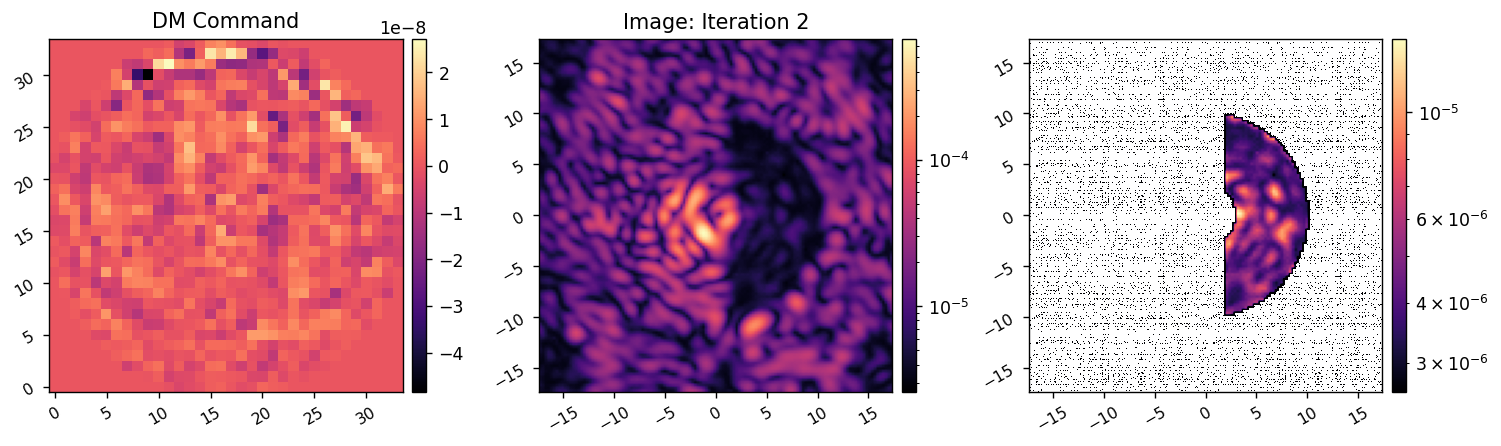

iEFC loop completed in 5.422s.


In [110]:
reload(lina.iefc)

probe_amp = 5e-9

condition = -2
# condition = -4
control_matrix = lina.utils.beta_reg(response_matrix, condition)

Nitr = 3

images, dm_commands = lina.iefc.run(tbi,
                                    control_matrix, 
                                    probe_modes, 
                                    probe_amp,
                                    calib_modes,
                                    control_mask,
                                    num_iterations=Nitr,
                                    loop_gain=0.25,
                                    leakage=0.0,
                                    plot_all=True,
                                    old_images=images,
                                    old_dm_commands=dm_commands,
                                    )

In [112]:
tbi.attenuation = 5

In [132]:
tbi.Nframes = 5

In [130]:
tbi.attenuation = 1

In [140]:
tbi.exp_time = 0.5*u.s

In [137]:
tbi.dm_delay = 1

Running iEFC ...
	Closed-loop iteration 1 / 2
	Mean NI of this iteration: 5.370e-08


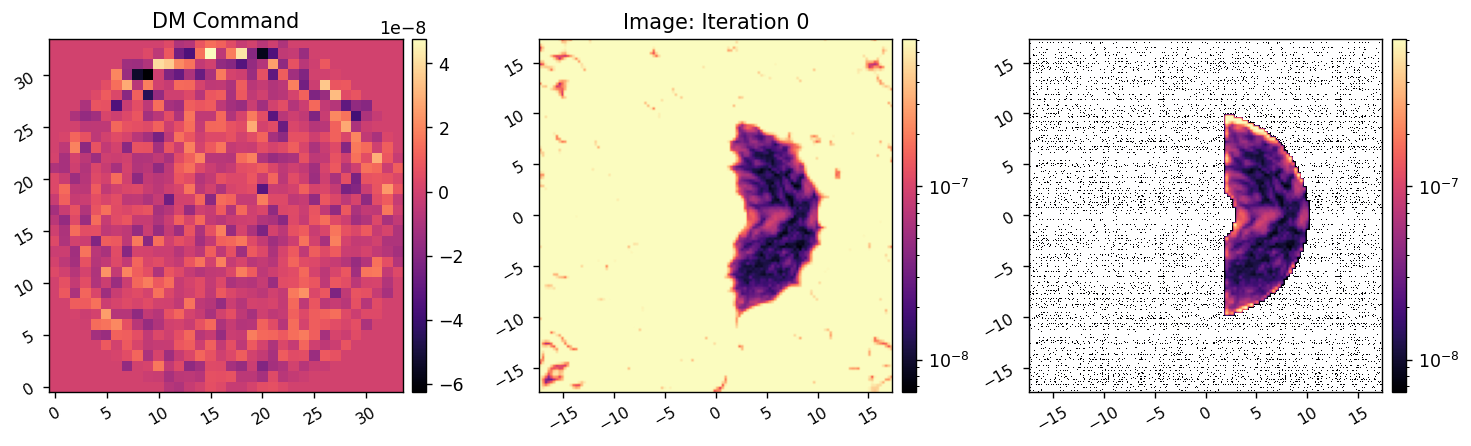

	Closed-loop iteration 2 / 2
	Mean NI of this iteration: 4.880e-08


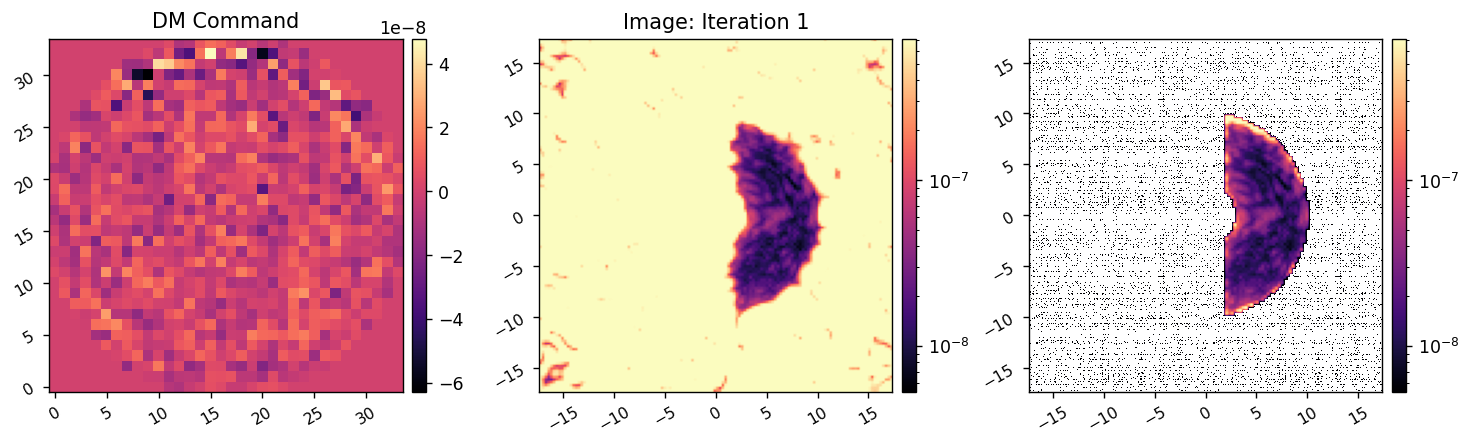

iEFC loop completed in 26.492s.


In [134]:
reload(lina.iefc)


probe_amp = 0.5e-9

condition = -2
# condition = -4
control_matrix = lina.utils.beta_reg(response_matrix, condition)

Nitr = 2

images, dm_commands = lina.iefc.run(tbi,
                                    control_matrix, 
                                    probe_modes, 
                                    probe_amp,
                                    calib_modes,
                                    control_mask,
                                    num_iterations=Nitr,
                                    loop_gain=0.25,
                                    leakage=0.0,
                                    plot_all=True,
                                    old_images=images,
                                    old_dm_commands=dm_commands,
                                    )

Running iEFC ...
	Closed-loop iteration 1 / 2
	Mean NI of this iteration: 4.025e-08


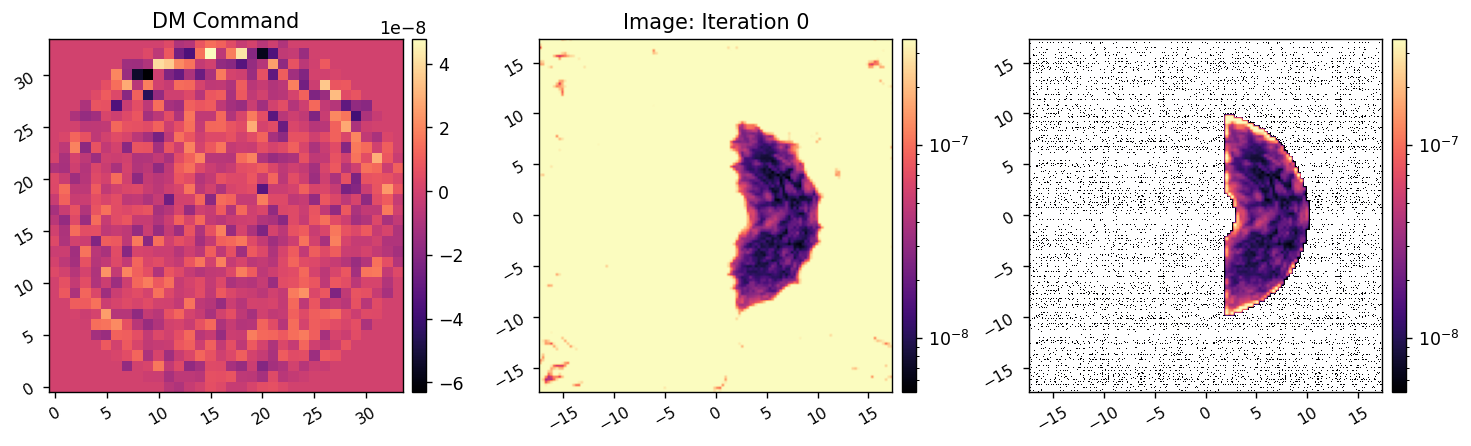

	Closed-loop iteration 2 / 2
	Mean NI of this iteration: 3.910e-08


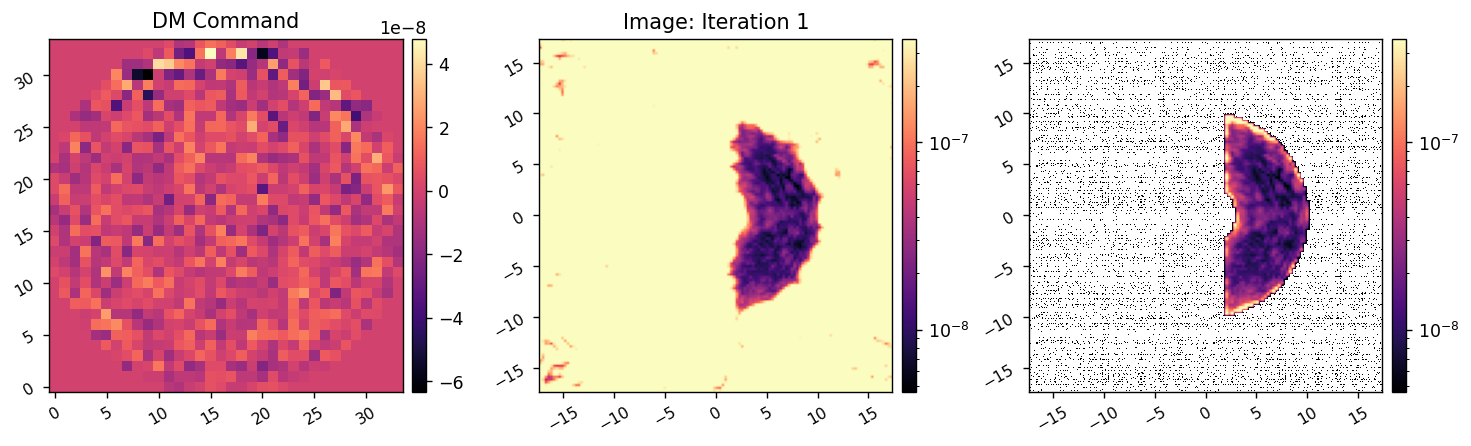

iEFC loop completed in 68.365s.


In [138]:
reload(lina.iefc)


probe_amp = 0.5e-9

condition = -2
condition = -5
control_matrix = lina.utils.beta_reg(response_matrix, condition)

Nitr = 2

images, dm_commands = lina.iefc.run(tbi,
                                    control_matrix, 
                                    probe_modes, 
                                    probe_amp,
                                    calib_modes,
                                    control_mask,
                                    num_iterations=Nitr,
                                    loop_gain=0.25,
                                    leakage=0.0,
                                    plot_all=True,
                                    old_images=images,
                                    old_dm_commands=dm_commands,
                                    )

In [144]:
tbi.exp_time = 0.5*u.s

In [148]:
tbi.gain = 10

Running iEFC ...
	Closed-loop iteration 1 / 2
	Mean NI of this iteration: 5.343e-08


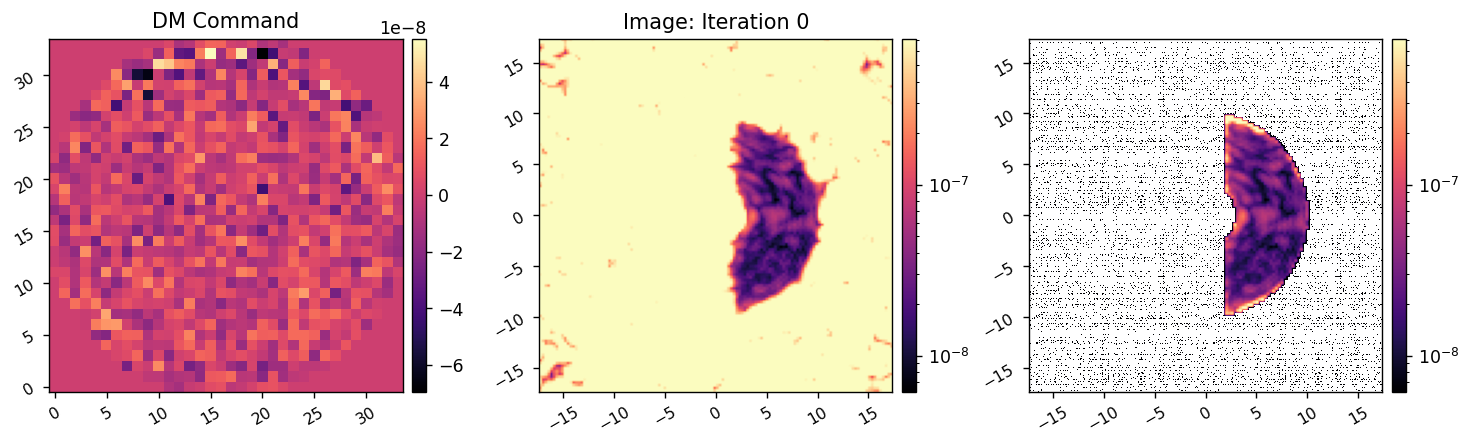

	Closed-loop iteration 2 / 2
	Mean NI of this iteration: 4.608e-08


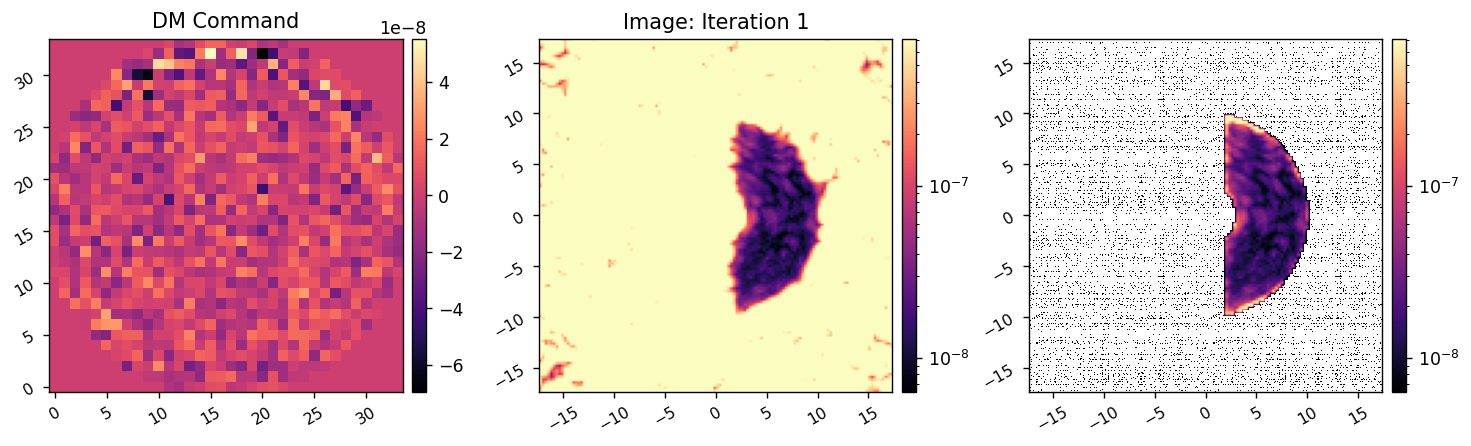

iEFC loop completed in 40.791s.


In [145]:
reload(lina.iefc)


probe_amp = 0.5e-9

condition = -2
# condition = -5
control_matrix = lina.utils.beta_reg(response_matrix, condition)

Nitr = 2

images, dm_commands = lina.iefc.run(tbi,
                                    control_matrix, 
                                    probe_modes, 
                                    probe_amp,
                                    calib_modes,
                                    control_mask,
                                    num_iterations=Nitr,
                                    loop_gain=0.25,
                                    leakage=0.0,
                                    plot_all=True,
                                    old_images=images,
                                    old_dm_commands=dm_commands,
                                    )